In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf
import imblearn
from sklearn.model_selection import train_test_split
import collections
from sklearn.metrics import roc_curve, auc

In [68]:
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name
signal='elec'
bkg = 'QCD'
savedir = workdir + '/moo/'+ bkg + '/'
os.makedirs(savedir, exist_ok=True)

In [67]:
workdir

'/grid_mnt/vol_home/llr/cms/hakimi/HGCAL'

In [4]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]


df_sig= pd.read_csv(data_dir+'/{}.csv'.format(signal), usecols=columns, low_memory=True)
if bkg == 'QCD':
    columns =['event', 'genjet_n', 'genjet_energy', 'genjet_pt', 'genjet_eta',
       'genjet_phi', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta',
       'cl3d_phi', 
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'layer', 'deta', 'dphi',
       'deltar', 'matches',]
elif bkg == 'PU':
    columns = ['event', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta', 'cl3d_phi', 
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'layer',]

df_bkg= pd.read_csv(data_dir+'/{}.csv'.format(bkg), usecols=columns, low_memory=True)
df_bkg['sample']=bkg

print('done')

done
CPU times: user 19.9 s, sys: 2.52 s, total: 22.4 s
Wall time: 22.4 s


In [5]:
"""df['genpart_exeta'][df['sample']=='PU']=0
df['genpart_pt'][df['sample']=='PU']=0
df['matches'][df['sample']=='PU']=0"""

"df['genpart_exeta'][df['sample']=='PU']=0\ndf['genpart_pt'][df['sample']=='PU']=0\ndf['matches'][df['sample']=='PU']=0"

# Config

In [6]:
genptcut=20
cl3dptcut=5
PU_cut = 20
etamin=1.6
etamax=2.9
#bkg='QCD' # 'pions' or 'PU'
standardize = "_unstandardized"
feature_set=16 # 1: baseline 4: minimal, 10-13 + new vars (12 -> PU 13-> pions)
opti=False
res_dir=workdir+'/res/res_pt{}_vs{}_featset{}{}'.format(genptcut, bkg, feature_set, standardize)
os.makedirs(res_dir, exist_ok=True)

In [7]:
from collections import Counter
count=Counter

In [8]:
%%time
df_sig['abseta']=np.abs(df_sig['cl3d_eta'])
df_bkg['abseta']=np.abs(df_bkg['cl3d_eta'])
sel = ((np.abs(df_sig['genpart_exeta'])>etamin) & (np.abs(df_sig['genpart_exeta'])<etamax )
       & (df_sig['genpart_pt']>genptcut)&  (df_sig['cl3d_pt']>cl3dptcut) 
       &(df_sig['abseta']>etamin) & (df_sig['abseta']<etamax ))
df_sig_cut=df_sig[sel]
df_sig_cut.dropna(inplace=True)
if bkg == 'QCD':
    sel = ((np.abs(df_bkg['cl3d_eta'])>etamin) & (np.abs(df_bkg['cl3d_eta'])<etamax )&(df_bkg['cl3d_pt']>cl3dptcut))
if bkg == 'pions':
    sel =  ((np.abs(df_bkg['genpart_exeta'])>etamin) & (np.abs(df_bkg['genpart_exeta'])<etamax )
       & (df_bkg['genpart_pt']>genptcut)&  (df_bkg['cl3d_pt']>cl3dptcut) 
       &(df_bkg['abseta']>etamin) & (df_bkg['abseta']<etamax ))
if bkg == 'PU':
    sel = ((np.abs(df_bkg['cl3d_eta'])>etamin) & (np.abs(df_bkg['cl3d_eta'])<etamax )&(df_bkg['cl3d_pt']>PU_cut))
df_bkg_cut=df_bkg[sel]
df_bkg_cut.dropna(inplace=True)
df_cut= df_sig_cut.append(df_bkg_cut)
print(count(df_cut['sample']))

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Counter({'elec': 207350, 'QCD': 135546})
CPU times: user 493 ms, sys: 130 ms, total: 623 ms
Wall time: 622 ms


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [9]:
%%time
#cut
algo_cut={}

def tolist(x):
    x.test=x.layer[1:-1].split(',')
    return x.test



#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))
#print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")
def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]

for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")



cl3d eta cut: 342896 207350
done
done layering36
CPU times: user 4min 27s, sys: 14.7 s, total: 4min 42s
Wall time: 4min 43s


In [10]:
Counter(df_cut['sample'])

Counter({'elec': 207350, 'QCD': 135546})

In [11]:
# build new vars

#abseta
#df_cut['abseta']=np.abs(df_cut['cl3d_eta'])

#variance
df_cut['varee']=df_cut['cl3d_seetot']**2
df_cut['varpp']=df_cut['cl3d_spptot']**2
df_cut['varzz']=df_cut['cl3d_szz']**2
df_cut['varrr']=df_cut['cl3d_srrtot']**2

#EoT: pt(Ecal)/pt(Tot)
nLayerEcal= 14
sumE=0

sumT=0
for i in range(n_layers):
    #print('Totlayer_{}'.format(i))
    sumT+=df_cut['layer_{}'.format(i)]
    
    
for i in range(1,nLayerEcal+1):
    #print('Ecal layer_{}'.format(i))
    sumE+=df_cut['layer_{}'.format(i)]
df_cut['EoT']=sumE/sumT

#fraction of pt in first x  layers and last x layers
maxfirst = 5
maxlast=10

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['first_{}'.format(n)]= Sum/sumT
    
for n in range(1,maxlast):
    Sum=0
    #print(n, ' layers')
    for i in range(n_layers - n, n_layers):
        #print(n,i)
        Sum+=df_cut['layer_{}'.format(i)]
    #print('last_{}'.format(n), sum/sumT)
    df_cut['last_{}'.format(n)]= Sum/sumT
    
    

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        #print('layer_{}'.format(nLayerEcal+i))
        Sum+=df_cut['layer_{}'.format(nLayerEcal+i)]
    df_cut['firstHcal_{}'.format(n)]= Sum/sumT
    
    
# Emaxx : pt in x layers around Elec max layer (5)
maxpos=5

#print('emax_1')
Sum=0
Sum+=df_cut['layer_{}'.format(maxpos)]
df_cut['Emax_1']=Sum/sumT
 
#print('emax_2L')
Sum=0
for i in range(maxpos-1, maxpos+1):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2L']=Sum/sumT
    
#print('emax_2R')
Sum=0
for i in range(maxpos, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2R']=Sum/sumT
    
#print('emax_3')
Sum=0
for i in range(maxpos-1, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_3']=Sum/sumT
#print('emax_4G')
Sum=0
for i in range(maxpos-2, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4L']=Sum/sumT
#print('emax_4R')
Sum=0
for i in range(maxpos-1, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4R']=Sum/sumT
#print('emax_5')
Sum=0
for i in range(maxpos-2, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_5']=Sum/sumT
    
    
    

In [12]:
%%time
#do bitmaps with group
def ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def hbm(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['ebm0']=df_cut.apply(ebm0, axis=1)
df_cut['ebm1']=df_cut.apply(ebm1, axis=1)
df_cut['hbm']=df_cut.apply(hbm, axis=1)

CPU times: user 4min 15s, sys: 8.26 s, total: 4min 23s
Wall time: 4min 18s


In [13]:
# try in last lay -> first

In [14]:
%%time
#do bitmaps with group
def reverse_ebm0(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_ebm1(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_hbm(x):
    ebm=[]
    thr=0
    for i in range(n_layers-1,nLayerEcal-1, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['reverse_ebm0']=df_cut.apply(reverse_ebm0, axis=1)
df_cut['reverse_ebm1']=df_cut.apply(reverse_ebm1, axis=1)
df_cut['reverse_hbm']=df_cut.apply(reverse_hbm, axis=1)
print('done')

done
CPU times: user 4min 19s, sys: 8.23 s, total: 4min 27s
Wall time: 4min 22s


In [15]:
#bitmap: for quantization, group layers
# max 16 bits (in realityn, 14 layers for ebm -> 14bits)
# possibilities: 7 bits (/2), 5 bist(/3), 4 bits(/4), 3bits(/5), 2 bits (/7)
x=df_cut.iloc[0]    
ebm=[]
thr=0

for i in range(1,nLayerEcal+1):
    #print(float(x.layer_pt[i])>thr)
    ebm.append(int(float(x['layer_pt'][i])>thr)) 
#print(ebm)

In [16]:
np.random.choice(a=[0, 1], size=14)  

array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1])

In [17]:
print(df_cut.columns.tolist())

['abseta', 'cl3d_coreshowerlength', 'cl3d_emaxe', 'cl3d_energy', 'cl3d_eta', 'cl3d_firstlayer', 'cl3d_hoe', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_maxlayer', 'cl3d_meanz', 'cl3d_ntc67', 'cl3d_ntc90', 'cl3d_phi', 'cl3d_pt', 'cl3d_seemax', 'cl3d_seetot', 'cl3d_showerlength', 'cl3d_sppmax', 'cl3d_spptot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_srrtot', 'cl3d_szz', 'deltar', 'deta', 'dphi', 'event', 'genjet_energy', 'genjet_eta', 'genjet_n', 'genjet_phi', 'genjet_pt', 'genpart_exeta', 'genpart_pt', 'matches', 'sample', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varr

In [18]:


if bkg == 'pions':
    name = 'minimal w/ var & best pions '
    features =['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_5', 'ebm1', 'Emax_4R', 'hbm', 'firstHcal_1', 'reverse_ebm1']
    
        
elif bkg == 'PU':
    name = 'minimal w/ var & best PU '
    features = ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT',
                'firstHcal_5', 'Emax_4R', 'ebm1', 'Emax_2R', 'firstHcal_1', 'Emax_5']
    
elif bkg == 'QCD':
    name = 'minimal w/ var & best QCD '
    features=  ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT','ebm1', 'Emax_4R',
                'reverse_ebm1', 'first_2', 'Emax_2R', 'Emax_5', 
                ]
    

In [19]:
#chose signal and background
#weight calc

df_cut['signal']= 5
df_cut['weight']=0
df_cut['signal'][df_cut['sample']=='elec']= 1
df_cut['signal'][df_cut['sample']!='elec'] = 0

if bkg == 'pions':
    print('pions')

    data=df_cut[df_cut['sample']!='PU']
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='pions'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))
elif bkg == 'QCD':
    print('QCD')

    data=df_cut
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='QCD'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))

elif bkg == 'PU':
    print('PU')
    data=df_cut[df_cut['sample']!='pion']
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='PU'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event

    data['weight'][data['signal']==0]=wb
    data['weight'][data['signal']==1]=ws
print('signal weight = {}, bkg weight ={}'.format(ws, wb))

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


QCD
signal weight = 1.6537062937062936, bkg weight =2.5297389816003424


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [20]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [21]:
balancing='comb' #'SMOTE', 'weights', 'ada', 'under', 'comb'

In [22]:
Counter= collections.Counter

In [23]:
print(data.columns.to_list())

['abseta', 'cl3d_coreshowerlength', 'cl3d_emaxe', 'cl3d_energy', 'cl3d_eta', 'cl3d_firstlayer', 'cl3d_hoe', 'cl3d_layer10', 'cl3d_layer50', 'cl3d_layer90', 'cl3d_maxlayer', 'cl3d_meanz', 'cl3d_ntc67', 'cl3d_ntc90', 'cl3d_phi', 'cl3d_pt', 'cl3d_seemax', 'cl3d_seetot', 'cl3d_showerlength', 'cl3d_sppmax', 'cl3d_spptot', 'cl3d_srrmax', 'cl3d_srrmean', 'cl3d_srrtot', 'cl3d_szz', 'deltar', 'deta', 'dphi', 'event', 'genjet_energy', 'genjet_eta', 'genjet_n', 'genjet_phi', 'genjet_pt', 'genpart_exeta', 'genpart_pt', 'matches', 'sample', 'layer_pt', 'layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_8', 'layer_9', 'layer_10', 'layer_11', 'layer_12', 'layer_13', 'layer_14', 'layer_15', 'layer_16', 'layer_17', 'layer_18', 'layer_19', 'layer_20', 'layer_21', 'layer_22', 'layer_23', 'layer_24', 'layer_25', 'layer_26', 'layer_27', 'layer_28', 'layer_29', 'layer_30', 'layer_31', 'layer_32', 'layer_33', 'layer_34', 'layer_35', 'varee', 'varpp', 'varzz', 'varr

# Multi objective optimization

## 1. Select genes
Here the genesa re the different paramaters of the optimization, so the quantization paramaters for each feature (add 0 parameter for forgetting the feature?

-> alleles for each gene is the number of bits [2-12], and for now method =qauntile
-> add exception for discrete variables: 2**nbits <= range

In [24]:
def maxbits(feat, maxbit):
    if feat.dtype == 'float64':
        return maxbit
    elif feat.dtype =='int64':
        nval = len(np.unique(feat))
        print(nval)
        for i in range(1,maxbit) : 
            if 2**i >= nval: return(i)
        return(i)

In [25]:
maxbits(data['ebm1'],16)

3695


12

In [26]:
#change discrete functuions type to int
discrete_cols = ['cl3d_showerlength','cl3d_coreshowerlength', 'cl3d_firstlayer', 'cl3d_maxlayer' ]
data[discrete_cols]=data[discrete_cols].astype('int64')


In [27]:

X_train, X_test, y_train, y_test = train_test_split(data[features], 
                                                    data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']],
                                                    test_size=0.2,random_state=42)
train_untouched=xgb.DMatrix(data=X_train,label=y_train['signal'],feature_names=features)
y_train_untouched=y_train
X_train_untouched=X_train
over_ratio = 0.2
under_ratio = 0.5
if bkg == 'QCD':
    over_ratio = 0.8
    under_ratio = 1
over=imblearn.over_sampling.SMOTE(sampling_strategy=over_ratio, random_state=42)
under= imblearn.under_sampling.RandomUnderSampler(sampling_strategy=under_ratio, random_state=42)
X_train, y_train=over.fit_resample(X_train,y_train['signal'])
X_train, y_train=under.fit_resample(X_train, y_train)
y_train=pd.DataFrame(y_train)
y_train['weight']=1



In [28]:
import pymoo
#problem definition

In [29]:
#nvar
nvar = len (data[features].columns)
print('nvar',nvar)

#nobj
nobj = 2 # efficiency and number of bits used

#nconstr
nconstr = 0

bitmin= 0 #0 if we want to remove features

# varaiables lower bound xl
xl=[bitmin for feat in data[features].columns]
print('lower bounds',xl)

bitmax = 12
#upper bound
xu =[maxbits(data[feat], bitmax) for feat in data[features].columns]
print ('upper bounds',xu)

param = {
        'nthread' : 8,
        # Parameters that we are going to tune.
        'max_depth':2,
        'eta':0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        # Other parameters
        'objective':'binary:logistic',
        'eval_metric': 'auc', 
        'alpha':0.01,
        'lambda':10,
    }

nvar 16
lower bounds [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
22
50
33
3695
3695
upper bounds [12, 5, 12, 12, 12, 12, 12, 6, 6, 12, 11, 12, 11, 12, 12, 12]


In [30]:
# quantization

def quantize(feat, nbits, method, fmin, fmax): #feat is the feature to quantize, nbist the number of bits, method: 'uniform' or 'percentile'
    nbins= 2**nbits
    if feat.dtype == 'float64':
        method = method
    elif feat.dtype == 'int64':
        method = 'uniform'
    if method == 'uniform':
        bins=np.linspace(fmin, fmax, nbins+1)
    elif method == 'percentile':
        bins=[np.percentile(feat, n) for n in np.linspace(0,100,nbins+1)]
    else :
        print('Error: Invalid method')
        return
    
    
    #print(feat.dtype,nbits, method)
    return np.digitize(feat, bins)

def quantize_ebm0(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.ebm0)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm


def quantize_ebm1(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.ebm1)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_hbm(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.hbm)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_reverse_ebm0(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.reverese_ebm0)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_reverse_ebm1(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm =int(x.reverese_ebm1)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm
def quantize_reverese_hbm(x,nb):
    qbm=[]
    nlay=14
    fuse_lay=int(np.ceil(nlay/nb))
    print(" nb", nb)
    bm = int(x.reverse_hbm)
    print('bm =', bm)
    bm = list(bin(bm))[2:]
    print('bits =', bm)
    while len(bm) < nlay:
        bm.insert(0,0)
    print('bits(nlay)=', bm)
    for j in range(0,14,fuse_lay):
        val=0
        #print("j",j)
        for k in range(fuse_lay):
            #print("k",k)
            if j+k <=13:
                val +=int(bm[j+k])
        #print("val", val)
        qbm.append(int(val>0))
    print(qbm)
    return qbm

In [31]:
Counter(y_train['signal'])

Counter({0: 132643, 1: 132643})

In [38]:
import numpy as np

from pymoo.factory import get_algorithm, get_crossover, get_mutation, get_sampling, get_selection
from pymoo.optimize import minimize
from pymoo.model.problem import Problem


class MyProblem(Problem):

    def __init__(self):
        super().__init__(n_var=nvar, n_obj=nobj, n_constr=nconstr, xl=xl, xu=xu, type_var=int, elementwise_evaluation=True)

    def _evaluate(self, x, out, *args, **kwargs):
        #define evaluations functions (minimization)
        #f1 = bkg eff at 99% signal efficiency
        #print(x)
        #it=pd.DataFrame([x], columns=features)
        #print(it)
        qtrain=pd.DataFrame()
        qtest=pd.DataFrame()
        feat_kept=features.copy()
        for i,feat in enumerate(X_train.columns):
            #print("feature :", feat, "quantized on {} bits".format(x[i]))
            if x[i]==0: #drop feat
                #print("dropping {} from {}".format(feat, feat_kept))
                feat_kept.remove(feat)
            elif 'bm' not in 'feat':
                qtrain[feat]=quantize(X_train[feat], x[i], 'uniform', data[feat].min(), data[feat].max())
                qtest[feat]=quantize(X_test[feat], x[i], 'uniform', data[feat].min(), data[feat].max())
            elif feat == 'ebm0':
                qtrain[feat]=X_train.apply(quantize_ebm0, nb = x[i], axis=1)
                qtest[feat]=X_test.apply(quantize_ebm0, nb = x[i], axis=1)
            elif feat == 'ebm1':
                qtrain[feat]=X_train.apply(quantize_ebm1, nb = x[i], axis=1)
                qtest[feat]=X_test.apply(quantize_ebm1, nb = x[i], axis=1)
            elif feat == 'hbm':
                qtrain[feat]=X_train.apply(quantize_hbm, nb = x[i], axis=1)
                qtest[feat]=X_test.apply(quantize_hbm, nb = x[i], axis=1)
            elif feat == 'reverse_ebm0':
                qtrain[feat]=X_train.apply(quantize_reverse_ebm0, nb = x[i], axis=1)
                qtest[feat]=X_test.apply(quantize_reverse_ebm0, nb = x[i], axis=1)
            elif feat == 'reverse_ebm1':
                qtrain[feat]=X_train.apply(quantize_reverse_ebm1, nb = x[i], axis=1)
                qtest[feat]=X_test.apply(quantize_reverse_ebm1, nb = x[i], axis=1)
            elif feat == 'reverse_hbm':
                qtrain[feat]=X_train.apply(quantize_reverse_hbm, nb = x[i], axis=1)
                qtest[feat]=X_test.apply(quantize_reverse_hbm, nb = x[i], axis=1)
        #print("test")       
        #print(qtrain.head(1))
        train= xgb.DMatrix(data=qtrain,label=y_train['signal'], feature_names=feat_kept, weight=y_train['weight'])
        test= xgb.DMatrix(data=qtest,label=y_test['signal'],feature_names=feat_kept)
        #print("test2")
        #use gpu if available
        gpu=tf.test.is_gpu_available(
            cuda_only=False, min_cuda_compute_capability=None
        )
        if gpu==True:
            param['tree_method']='gpu_hist'

        num_boost_round=200
        es_rounds=3

        metrics={'logloss','auc'} #last one used for es
        # set up cross validation:
        #print('beginning cv')
        cv_results = xgb.cv(
            param,
            train,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=metrics,
            #feval=SoverB,
            early_stopping_rounds=es_rounds,
            shuffle=True,
            verbose_eval=None
        )

        ## we define best score as the best test_auc penalized by the gap between train and test auc
        alpha=1 #(penalization)

        best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
        boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
        #Now train and fit best parameters BDT
        eval_result = {}
        BDT = xgb.train(
            param,
            train,
            num_boost_round=int(boost_rounds),
            #feval = SoverB,
            evals=[(train, 'Train'),(test, "Test")],
            evals_result = eval_result,
            verbose_eval=None,
        )
        pred= BDT.predict(test)
        
      
        fpr, tpr, threshold = roc_curve(y_test['signal'],pred, pos_label=1)
        fpr.sort()
        tpr.sort()
        roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
        
        #return bkg eff at 0.99 signal efficiency
        #f1=np.interp(0.99,roc_test['tpr'],roc_test['fpr'])
        
        
        #return auc at > cut sig eff
        cut=0.8
        
        roc_thr=roc_test[roc_test['tpr']>0.8]
        if len(roc_thr)>3:
            f1= (-1)*auc(roc_thr['fpr'], roc_thr['tpr']) # negative to be a minimization
        else : 
            f1 = 0
        #f2 = total numer of bits used
        f2=int(sum(x))
        #print('parameters: {} \n bkg efficiency = {}, using {} bits'.format(x,f1, f2))
        out["F"] = [f1, f2]
problem=MyProblem()

342896

In [39]:
pd.options.mode.chained_assignment = None  # default='warn'    
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning)


#hyperdiagonal sampling:
#range=[0,12] (add if 13 -> no quantization?but then, how to quantify number of bits used?)
max_val=12
sampling=[]
for i in range(1,max_val+1):
    sampling.append(np.full( problem.n_var, i))
sampling=np.array(sampling)
#sampling= get_sampling("int_random")
#will there be a probleme because sampling size < pop size? if yes, so what?

method = get_algorithm("nsga2",
                       pop_size=60,
                       sampling=sampling,
                       crossover=get_crossover("int_sbx", prob=1.0, eta=3.0),
                       mutation=get_mutation("int_pm", eta=3.0),
                       eliminate_duplicates=True,
                       )


res = minimize(problem,
               method,
               termination=('n_gen', 40),
               seed=42,
               save_history=True,
               verbose=True
               )

print("Best solution found: %s" % res.X)
print("Function value: %s" % res.F)
print("Constraint violation: %s" % res.CV)

parameters: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 
 bkg efficiency = -0.8992697233076462, using 16 bits
parameters: [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] 
 bkg efficiency = -0.9629714321314017, using 32 bits
parameters: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3] 
 bkg efficiency = -0.9965158099112706, using 48 bits
parameters: [4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4] 
 bkg efficiency = -0.9977552012155649, using 64 bits
parameters: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5] 
 bkg efficiency = -0.9981452014114773, using 80 bits
parameters: [6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6] 
 bkg efficiency = -0.9984654494089739, using 96 bits
parameters: [7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7] 
 bkg efficiency = -0.9986130372880717, using 112 bits
parameters: [8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8] 
 bkg efficiency = -0.9986556182484604, using 128 bits
parameters: [9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9] 
 bkg efficiency = -0.9986465384652081, using 144 bits
parameters: [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10] 
 bkg efficiency = -0.9987221064259

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 9  6  4  9  5  9  9  6  5  9  9  8  8  8 11  8] 
 bkg efficiency = -0.9986523172780339, using 123 bits
parameters: [10  6 10 10 10 10 10  6  5  5  5 10  5  5 10  9] 
 bkg efficiency = -0.9984153325312045, using 126 bits
parameters: [1 1 1 1 3 1 3 1 3 3 1 1 4 3 1 1] 
 bkg efficiency = -0.9646011374797743, using 29 bits
parameters: [1 2 2 2 1 1 1 1 2 2 2 2 0 2 2 2] 
 bkg efficiency = -0.9588648878071958, using 25 bits
parameters: [11  6  9 10  9  9  9  6  6  9  9  9  9  9 10  9] 
 bkg efficiency = -0.9986747273726077, using 139 bits
parameters: [ 5  6  5  5 11  4  5  5  5  5 10  1  5  9  5  5] 
 bkg efficiency = -0.9985039512335543, using 91 bits
parameters: [8 6 8 8 8 8 8 6 6 5 8 8 9 6 8 8] 
 bkg efficiency = -0.9986507084166556, using 118 bits
parameters: [10  6 10 10 10  9 10  6  6  9  9  9  9 10 10 10] 
 bkg efficiency = -0.9986529561037335, using 143 bits
parameters: [12  6 11 11 11 12 12  5  6 12 12 12 11 12 12 12] 
 bkg efficiency = -0.9986906383616849, using 169 bit

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 7  6  7  7 10 11 10  6  6 11  7 11  7  7  7  7] 
 bkg efficiency = -0.998619423764368, using 127 bits
parameters: [ 2  6  2  5  9  2  2  2  5  6  3  8  1 10  3 10] 
 bkg efficiency = -0.9958466847310964, using 76 bits
parameters: [ 1  4  3 10  1  1  3  3  1  1  3  1  9  1  4  2] 
 bkg efficiency = -0.9957461375725666, using 48 bits
parameters: [ 1  6 10  9 10  7 10  6  6 10 10  1  8  9  4 10] 
 bkg efficiency = -0.9985537444693142, using 117 bits
parameters: [11  1  1  1  2  2  2  2  1  1  8  1  1 12  1  1] 
 bkg efficiency = -0.9899378150058428, using 48 bits
parameters: [ 2  1  4  5  3  1  4  4  1 10  9  1  2  1  1  0] 
 bkg efficiency = -0.9958105102798657, using 49 bits
parameters: [11  3  2 10 11  7  3  6  3 10  4  4 11  3  2  7] 
 bkg efficiency = -0.9985052182007604, using 97 bits
parameters: [10  5  1  2  4  1  8  6  6  8  8  3  2  1 10  7] 
 bkg efficiency = -0.9944869012703402, using 82 bits
parameters: [ 7  6  2 10  2  1 10  6  2  2  1  1  3  2  2 12] 
 bkg eff

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [4 4 5 4 4 3 4 3 6 3 8 9 3 4 2 4] 
 bkg efficiency = -0.9977485899260433, using 70 bits
parameters: [ 2  1  1  8  1  1  1  1  5  3  8  1  9 10  1  1] 
 bkg efficiency = -0.9958804049341867, using 54 bits
parameters: [0 2 1 4 1 3 1 2 2 0 2 1 3 2 2 2] 
 bkg efficiency = -0.9892582446916005, using 28 bits
parameters: [5 6 2 6 7 1 1 6 2 4 2 7 0 2 2 2] 
 bkg efficiency = -0.9926532066338111, using 55 bits
parameters: [1 4 6 3 2 3 0 4 1 1 1 1 2 1 1 0] 
 bkg efficiency = -0.9613946153185021, using 31 bits
parameters: [8 6 8 8 8 8 8 6 6 5 8 9 7 6 8 8] 
 bkg efficiency = -0.9986232317887817, using 117 bits
parameters: [11  6 10 10 10 10 10  6  6  9 10 10 10  8  8  8] 
 bkg efficiency = -0.998688465909132, using 142 bits
parameters: [ 0  2  2  3  2  3  2  2  2  2  4  4 11  2  2  2] 
 bkg efficiency = -0.9975161241476289, using 45 bits
parameters: [ 4  4  9  9 10  9  3  6  3  9 11  3 10  9  9  9] 
 bkg efficiency = -0.9985977976224473, using 117 bits
parameters: [10  6  5  5  6  4 12 

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 3  6  1  1 11 10  9  6  6 10 10  1  1 10  2 11] 
 bkg efficiency = -0.9983974075717685, using 98 bits
parameters: [11  6 12 12 11 11 12  6  6 12 12 12 12 11 10 12] 
 bkg efficiency = -0.9987187008394687, using 168 bits
parameters: [ 6  6  9  2  8  6  6  6  6  7  7  5  7  6 12  3] 
 bkg efficiency = -0.9983878830589875, using 102 bits
parameters: [ 5  2  6  9  7 10  2  3  6  9 11 10  8 12  3  6] 
 bkg efficiency = -0.998683057926834, using 109 bits
parameters: [1 5 5 4 1 4 1 3 1 1 4 5 7 5 3 0] 
 bkg efficiency = -0.9979012064985919, using 50 bits
parameters: [12  6  0  9 10 12  6  6  6 11 11  2 10  9  9 11] 
 bkg efficiency = -0.9987159474339278, using 130 bits
parameters: [ 1  6 12  2 10 11  1  6  6  1 11  3  6 10  0  1] 
 bkg efficiency = -0.9983325322622293, using 87 bits
parameters: [1 1 4 1 1 2 1 1 3 2 1 1 3 2 1 0] 
 bkg efficiency = -0.9762573973745611, using 25 bits
parameters: [ 0  6  3  0  1  0  0  1  2  9 11  2  1 12  1  1] 
 bkg efficiency = -0.9959478992065067,

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 4  3  8 12  8  8 12  6  6  3  8 12 12  7 10 12] 
 bkg efficiency = -0.9986502765971932, using 131 bits
parameters: [10  6  6  5  7 10  6  6  6 10  7 10  8  7  6  6] 
 bkg efficiency = -0.998617266447755, using 116 bits
parameters: [10  6 10 10  8 10 10  6  6 10 10 10 10 10 10 10] 
 bkg efficiency = -0.9987215668742098, using 146 bits
parameters: [12  6  0  3 10 12  5  6  1  9 11  2 11  1  9  2] 
 bkg efficiency = -0.9985070126999902, using 100 bits
parameters: [1 3 6 0 1 4 1 1 1 1 2 2 1 1 1 1] 
 bkg efficiency = -0.9888230855285915, using 27 bits
parameters: [11  6 11 12  9 11 11  6  6 10 11 12 12 11 11 11] 
 bkg efficiency = -0.9986564961329757, using 161 bits
parameters: [ 8  2  1  5  0 12  8  6  6 10  1  1  1  9  7  9] 
 bkg efficiency = -0.9972407956132385, using 86 bits
parameters: [ 6  3  9  4  6  6  5  6  3  0 11  4  3  1  8  3] 
 bkg efficiency = -0.9985362379740995, using 78 bits
parameters: [ 0  0  1  0  1  3  0  1  1  1 11  1  3  1  1  0] 
 bkg efficiency = -0.

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [10  6 10  9 11 10 10  6  6 10 10  9  7 11  8 10] 
 bkg efficiency = -0.9986573241579243, using 143 bits
parameters: [ 1  1  1  1  1  2  1  1  1  1 11  4  1  1  1  1] 
 bkg efficiency = -0.995078817575815, using 30 bits
parameters: [2 2 7 0 3 3 2 2 2 2 2 4 2 2 8 1] 
 bkg efficiency = -0.9946660395710237, using 44 bits
parameters: [ 6  3  3  4  6  3  0  6  3  4 11  7  3  1  1  3] 
 bkg efficiency = -0.9981957683608718, using 64 bits
parameters: [1 3 2 2 1 7 1 1 1 0 1 2 8 1 1 1] 
 bkg efficiency = -0.9963892253746831, using 33 bits
parameters: [12  6  0  0  1  3  9  1  2 12 11  2  6 11  1  1] 
 bkg efficiency = -0.9978092160430378, using 78 bits
parameters: [ 1  6 10  1  7 10  0  1  2  1 11  8  3  1  0  1] 
 bkg efficiency = -0.9983578885229905, using 63 bits
parameters: [ 6  0 10  4  6  8  6  1  5  1 11  1  2  1  1  0] 
 bkg efficiency = -0.9983130901474038, using 63 bits
parameters: [ 0  6  4  3  0  1  2  1  2 10  4  4  3  2  2  2] 
 bkg efficiency = -0.9920351149461206, us

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [10  6 10 10 10 10 10  6  6 10 12 10 10 10 10 10] 
 bkg efficiency = -0.9987203479858716, using 150 bits
parameters: [0 0 1 7 2 9 1 3 6 2 1 2 6 1 1 0] 
 bkg efficiency = -0.9961452487139606, using 42 bits
parameters: [ 3  2  9  8  7  8  1  6  0  1 10  5  8 12  3  4] 
 bkg efficiency = -0.9986497842339712, using 87 bits
parameters: [ 6  3  6  4 12  3  6  6  3  0 10  4  3  3  1  3] 
 bkg efficiency = -0.9982161871889966, using 73 bits
parameters: [ 9  1 12 12  1 11  3  6  6 11 10  1 12  2 11 12] 
 bkg efficiency = -0.9987036663993826, using 120 bits
parameters: [ 1  1  1  1  1  2  1  1  1  1 11  5  1  1  1  1] 
 bkg efficiency = -0.9955458922036664, using 31 bits
parameters: [12  6 12 10  1 12  6  6  6 11 11  1 10  9  9 11] 
 bkg efficiency = -0.9986871691152207, using 133 bits
parameters: [ 1  3  2  3  1  3  3  6  1  3  2  1 11  4  1  1] 
 bkg efficiency = -0.9917563349722542, using 46 bits
parameters: [ 5  0  2  1  1  5  0  3  6  2 11  2  0 12  3  2] 
 bkg efficiency = -0.9

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 4  2  9  8 10  4  2  3  6  2 11  1  0  1  1  7] 
 bkg efficiency = -0.9983463967831947, using 71 bits
parameters: [ 1  1  2  7  7  9  1  1  6  3  9  3  9 10  2  4] 
 bkg efficiency = -0.9983442951134196, using 75 bits
parameters: [ 2  0  2  1  1  5  0  3  1  0  0  0  3 12  3  2] 
 bkg efficiency = -0.9536851715094843, using 35 bits
parameters: [ 7  6  2  9 10  7  5  6  6  7 11 10  9  2  8  1] 
 bkg efficiency = -0.9985924234734267, using 106 bits
parameters: [ 0  0  3  0  1  2  0  1  2  0 11  1  3  1  1  0] 
 bkg efficiency = -0.9933760599489493, using 26 bits
parameters: [ 1  1  1  1  2 10  1  1  1  1  1  1  3  1  1 12] 
 bkg efficiency = -0.9921949500264863, using 39 bits
parameters: [ 1  1 10  1  7 10  0  1  2  1 11  8  6  1  0  1] 
 bkg efficiency = -0.9982766481461762, using 61 bits
parameters: [ 0  0  1  0  8  3  0  1  0  1 11  2 10  1  9  0] 
 bkg efficiency = -0.9975371693365616, using 47 bits
parameters: [ 0  6 10  0  1 12  0  1  2 11 11  1  3  1  3  3] 
 bkg eff

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 1  0  1  0 10  3  0  1  6  2 11  2  0  1  1  0] 
 bkg efficiency = -0.9973653568307986, using 39 bits
parameters: [ 1  1  1  7  1  2  1  1  5  2 11  1  8 10  1  0] 
 bkg efficiency = -0.9958536116494826, using 53 bits
parameters: [ 2  0  2  1  1  5  0  3  1  0  0  0  3 12  3  2] 
 bkg efficiency = -0.9536851715094843, using 35 bits
parameters: [ 8  6  1  9  9  3  0  6  1  3 11 10  3  1  1  1] 
 bkg efficiency = -0.9982551025808768, using 73 bits
parameters: [ 1  3  4  1  1  9  0  1  6  2 11  1  8  1  3  0] 
 bkg efficiency = -0.9980590218213279, using 52 bits
parameters: [ 1  3  1  1  6 11  1  1  1  1  1  1  2  1  1  7] 
 bkg efficiency = -0.9903161204622947, using 40 bits
parameters: [ 7  0 12 12  2 11  2  6  6  1 12  1 12  1  0  4] 
 bkg efficiency = -0.9986874130709582, using 89 bits
parameters: [ 0  0  2  3  1  0  0  1  1  1 11  7 11  1  2  2] 
 bkg efficiency = -0.9963301097354575, using 43 bits
parameters: [ 0  3  8  0  1  0  0  2  2  1 11  2  0  1  1  1] 
 bkg effi

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 0  2  1  0  1  3  0  1  2  1 11  1  2  1  3  1] 
 bkg efficiency = -0.9942142108412427, using 30 bits
parameters: [ 0  0  1  7  1 10  0  2  6  0  0  1 10  1  1  0] 
 bkg efficiency = -0.9961754889863939, using 40 bits
parameters: [6 1 2 1 2 2 0 5 2 1 1 1 3 1 7 3] 
 bkg efficiency = -0.9826472107003787, using 38 bits
parameters: [10  6 10 10 12 10 10  6  6 10 10 10 10 11 10 10] 
 bkg efficiency = -0.9986883118786846, using 151 bits
parameters: [ 8  1  1 11  1  1  2  1  1 11  0  1  9  1  1 10] 
 bkg efficiency = -0.9961640671390264, using 60 bits
parameters: [ 1  0  1  0  1  3  1  1  1  1 11  2  0  1  1  1] 
 bkg efficiency = -0.9972042067043588, using 26 bits
parameters: [ 1  3  2  3  1  7  1  1  1  1 11  2  0  1  1  1] 
 bkg efficiency = -0.9978729637250532, using 37 bits
parameters: [10  0  1  0  8  8  9  6  6 10 10  1  9  9 10 10] 
 bkg efficiency = -0.9984401995449665, using 107 bits
parameters: [11  0  1  1  8 12  0  2  6  1 10  2 10 10 10  3] 
 bkg efficiency = -0.99

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 1  2  1  1  1  2  0  1  5  1 11  1  8  1  1  1] 
 bkg efficiency = -0.9937274456910812, using 38 bits
parameters: [ 1  0  1  0  9 12  3  1  6  0 11  1  6  1  2 11] 
 bkg efficiency = -0.9983728450575036, using 65 bits
parameters: [ 7  1 12 10  2 11  2  5  6  1  1  1 12  1  0  4] 
 bkg efficiency = -0.9981092344116584, using 76 bits
parameters: [ 1  0  1  1  1  0  0  1  2  1 10  1  0  1  1  1] 
 bkg efficiency = -0.985156328848787, using 22 bits
parameters: [ 2  1  2  2  1  8  7  1  5  1 11  3  6  0  1  5] 
 bkg efficiency = -0.99846659617901, using 56 bits
parameters: [ 0  6  0  0 11  9  1  1  6  1 10  1  9 10  1  9] 
 bkg efficiency = -0.998412264387148, using 75 bits
parameters: [ 6  3  2  1  1  7  0  1  1  1 10  2  8  4  1  1] 
 bkg efficiency = -0.9981668400182897, using 49 bits
parameters: [0 0 1 0 1 3 1 1 2 1 0 1 3 3 1 3] 
 bkg efficiency = -0.967317677213303, using 21 bits
parameters: [ 6  0  1  4  6  6  5  1  3  0 10  0  3  1  8  3] 
 bkg efficiency = -0.998428470

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [0 0 1 0 1 3 1 1 2 1 1 1 3 5 0 1] 
 bkg efficiency = -0.9818133357111123, using 21 bits
parameters: [0 1 1 0 1 0 1 1 1 1 1 5 0 1 1 1] 
 bkg efficiency = -0.9507124426375924, using 16 bits
parameters: [0 1 7 0 2 3 1 1 2 2 1 1 6 1 7 1] 
 bkg efficiency = -0.9953228383088332, using 36 bits
parameters: [11  3  2  2  2  8  0  5  5  2 11  5  1  1  1 11] 
 bkg efficiency = -0.9984117720239261, using 70 bits
parameters: [ 3  0  2 10  1 11  1  1  3  1 10  1  8 10 10  4] 
 bkg efficiency = -0.9985791078528707, using 76 bits
parameters: [12  6  0 10 10 10  7  6  6 11 11  2 10 10 10 10] 
 bkg efficiency = -0.998688111550068, using 131 bits
parameters: [ 1  1 10  1  7 10  0  1  1  1 11  9  6  1  0  1] 
 bkg efficiency = -0.9982695106601552, using 61 bits
parameters: [11  1  2  2  1  0  0  1  5  1  0  1  0  1  1  0] 
 bkg efficiency = -0.9639099218404635, using 27 bits
parameters: [ 4  6  4  9  0  6  2  3  6  2 11  2  3 12  2  6] 
 bkg efficiency = -0.9986288040405452, using 78 bits
para

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 0  0  1  0  1  3  0  1  2  1 11  1  5  1  1  0] 
 bkg efficiency = -0.9971346285692518, using 28 bits
parameters: [10  1  2 10  2 11  0  2  0  1 10  2  0  3  1  1] 
 bkg efficiency = -0.9982466215576007, using 56 bits
parameters: [6 0 1 4 5 6 5 1 3 0 0 0 3 4 8 3] 
 bkg efficiency = -0.9962846756503942, using 49 bits
parameters: [0 0 1 0 1 0 0 1 1 1 2 1 0 1 1 0] 
 bkg efficiency = 0, using 10 bits
parameters: [11  0 11 10  8 10  0  2  6  9 10  1 10 10 10 12] 
 bkg efficiency = -0.9986494748375522, using 120 bits
parameters: [0 1 1 2 1 4 0 1 5 1 0 4 7 0 1 0] 
 bkg efficiency = -0.9966711033193113, using 28 bits
parameters: [5 0 1 2 0 3 0 1 1 0 0 1 1 4 2 2] 
 bkg efficiency = -0.9844665164001417, using 23 bits
parameters: [0 0 1 0 3 9 0 1 1 0 0 0 6 0 1 1] 
 bkg efficiency = -0.9943775552337958, using 23 bits
parameters: [0 0 1 0 1 3 1 1 1 0 1 1 3 1 1 0] 
 bkg efficiency = -0.9751484903372569, using 15 bits
parameters: [ 1  0 11  8  2  8  0  2  0  3 11  9  2  5  3  4] 
 bkg e

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 3  0  1  0  1  3  0  1  6  0 11  0  9  1  1  0] 
 bkg efficiency = -0.9961271358907998, using 37 bits
parameters: [ 0  1  1  1  7 10  9  1  1  0 11  1  4  1  2 11] 
 bkg efficiency = -0.9982675144967847, using 61 bits
parameters: [ 0  6 11  9  8  0  0  5  2 10  1 10  0  1  1  0] 
 bkg efficiency = -0.9863995419779108, using 64 bits
parameters: [ 5  0  9  7  6  8  0  6  4  2 11  1  8 12  3  0] 
 bkg efficiency = -0.9984480702337243, using 82 bits
parameters: [ 5  1  1  0  1  1  0  1  2  0 10  8 11  1  1  0] 
 bkg efficiency = -0.9957080938327558, using 43 bits
parameters: [ 0  0  0  0  9  9  0  1  6  0  0  1  9 10  1 10] 
 bkg efficiency = -0.9980811803921941, using 56 bits
parameters: [ 5  6  1 10 10 10  0  0  2  1 11  7 11 12  2  4] 
 bkg efficiency = -0.9987138315185621, using 92 bits
parameters: [0 0 1 4 1 0 0 1 1 1 1 0 3 1 1 2] 
 bkg efficiency = -0.953445384833071, using 17 bits
parameters: [ 0  0  0  2  8  5  1  1  2  1 10  1  6  1  1  1] 
 bkg efficiency = -0.99779

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 0  1  1 11  1  1  6  1  1  1  1  9  2  2  1  5] 
 bkg efficiency = -0.9767298755329636, using 44 bits
parameters: [ 7  6 12 12  5 11  2  6  6  8 12  5 10  1  0  4] 
 bkg efficiency = -0.9986675480401643, using 107 bits
parameters: [0 1 1 0 0 0 1 1 1 1 1 2 0 4 1 1] 
 bkg efficiency = -0.8886643690832209, using 15 bits
parameters: [0 0 1 0 1 0 0 1 1 1 0 0 4 1 1 0] 
 bkg efficiency = -0.6677260223464666, using 11 bits
parameters: [12  0 12  8  1 10  1  6  6  1 10  0  9  1  0 12] 
 bkg efficiency = -0.9986710577975269, using 89 bits
parameters: [1 0 1 0 1 3 0 1 2 0 0 1 4 1 1 0] 
 bkg efficiency = -0.9783730621068819, using 16 bits
parameters: [10  0  0  3  0 10 10  6  6 10 10  1  1 10  8  8] 
 bkg efficiency = -0.9984920997925981, using 93 bits
parameters: [ 5  6  1 10  1 10  7  0  2  1 11  4  2 12  2  4] 
 bkg efficiency = -0.9985710212543818, using 78 bits
parameters: [11  0  2 10  3 11  0  2  2  1 11  1 10 10 10  5] 
 bkg efficiency = -0.9986442867715579, using 89 bits
par

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [2 0 1 0 1 3 0 1 2 1 1 1 0 1 1 1] 
 bkg efficiency = -0.9790238919422671, using 16 bits
parameters: [0 1 1 1 1 0 0 1 2 1 0 3 0 0 1 0] 
 bkg efficiency = -0.8805652260163901, using 12 bits
parameters: [ 5  6  7  7  9 10  0  0  6  8 10  5  9  2  8  4] 
 bkg efficiency = -0.998675758397221, using 96 bits
parameters: [10  0  1  0  1  3  1  1  6  9 10  4  0  1  0 10] 
 bkg efficiency = -0.9978081538561954, using 57 bits
parameters: [ 0  0  1  0  2  3  0  1  1  1 11  1  3  1  1  0] 
 bkg efficiency = -0.9937117283529999, using 26 bits
parameters: [12  6  0 10 10 10  7  6  6 11 11  5 10 10 10 10] 
 bkg efficiency = -0.9986989960715683, using 134 bits
parameters: [11  0 12 10  4 11  0  2  6  1 10  1 10  1  2  5] 
 bkg efficiency = -0.9986682767911541, using 86 bits
parameters: [ 6  6  1  1  2 10  0  0  2  1 11  7 11 12  2  0] 
 bkg efficiency = -0.9984169093400043, using 72 bits
parameters: [ 5  6  1 10  0  4  0  0  2  1 10  5  4  2  2  4] 
 bkg efficiency = -0.9983708391002897, us

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [11  1  2 10  4 11  0  1  2  1 10  1  1 10  8 12] 
 bkg efficiency = -0.9984472092658477, using 85 bits
parameters: [ 7  0  8 11  8 10  2  6  6  1 12  8 12  1  0  2] 
 bkg efficiency = -0.9986238839697223, using 94 bits
parameters: [ 5  6  8  0  2  0  0  1  6  8 10  2  9  2  2  7] 
 bkg efficiency = -0.9980083622755951, using 68 bits
parameters: [2 0 1 0 9 3 0 1 2 0 1 1 3 3 0 0] 
 bkg efficiency = -0.9878831681442555, using 26 bits
parameters: [ 8  0  1 12  1  3  1  2  1 11  9  1  9  1  1 10] 
 bkg efficiency = -0.998323473402188, using 71 bits
parameters: [ 0  1  1  1  1  0  0  1  2  0 11  1  1  1  1  0] 
 bkg efficiency = -0.9881632627190214, using 22 bits
parameters: [ 2  1 11 11  1  7  7  1  1  1 11  0  3  1  1  5] 
 bkg efficiency = -0.9985308705026996, using 64 bits
parameters: [ 3  0  0  0  1  5  0  1  0  1 11  0  3  5  1  6] 
 bkg efficiency = -0.9982416204649817, using 37 bits
parameters: [ 0  0  1  1  1 12  0  1  2  2  1  1  6  1  1  2] 
 bkg efficiency = -0.99654

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 5  1  2 10 11  8  0  1  2  1 11  8  9  2  1  5] 
 bkg efficiency = -0.9986734844448355, using 77 bits
parameters: [ 6  0  2  5 12 11  3  1  0  2 10  5 10  1  1 10] 
 bkg efficiency = -0.9986640609867121, using 79 bits
parameters: [ 5  6  1  9 10  8  0  2  2  1  1  5 11  0  2  4] 
 bkg efficiency = -0.9981073250573552, using 67 bits
parameters: [10  0 10 10 10 10  2  6  6 10 10  2 10 10 10 10] 
 bkg efficiency = -0.9986526511590617, using 126 bits
parameters: [12  1  1 10  3  7  0  2  5  0 10  1 11  0  2 12] 
 bkg efficiency = -0.9985953540584999, using 77 bits
parameters: [ 2  2  0  2  1  8  0  1  2  1 11  0  8  1  1  5] 
 bkg efficiency = -0.998428671300845, using 45 bits
parameters: [10  0  1  0  1 10  8  1  2  0  0 10  0 10  1  1] 
 bkg efficiency = -0.9925751127518011, using 55 bits
parameters: [0 1 1 1 1 0 0 1 2 1 0 0 0 0 1 1] 
 bkg efficiency = -0.7103566335149576, using 10 bits
parameters: [0 0 1 0 8 0 0 1 1 1 0 0 0 1 1 0] 
 bkg efficiency = -0.8817938294020946, us

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 2  0  1  1  5 11  0  2  6  1 10  0  1 12  2 12] 
 bkg efficiency = -0.9983644993673373, using 66 bits
parameters: [ 0  6  1  0  1  0  0  1  1 10 11  3  0  1  2  0] 
 bkg efficiency = -0.9949174021252519, using 37 bits
parameters: [ 5  1  7  0 11  8  0  1  2  1 11  8  8  2  7  1] 
 bkg efficiency = -0.9983727756102498, using 73 bits
parameters: [2 0 1 0 1 3 0 1 2 1 0 4 0 1 0 0] 
 bkg efficiency = -0.9661417420015932, using 16 bits
parameters: [0 0 2 0 1 5 0 1 0 1 1 1 0 1 1 0] 
 bkg efficiency = -0.9775710073150716, using 14 bits
parameters: [12  6  0 10 10 10  7  6  6 11 11  1 10 10 10 10] 
 bkg efficiency = -0.998688111550068, using 130 bits
parameters: [ 1  0  2  1  7 10  0  1  1  1 10  1  0  1  0  0] 
 bkg efficiency = -0.9977472842286381, using 36 bits
parameters: [ 5  3  9  1  2 10  0  0  5  8 10  5  6  2  2  0] 
 bkg efficiency = -0.9984256899658559, using 68 bits
parameters: [ 2  6  2 10  1  6  0  1  5  1 10  7  6 12  2  4] 
 bkg efficiency = -0.9985363038599556, us

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 6  0  1 10  4 11  0  2  6  1 10  1 10 12  3 12] 
 bkg efficiency = -0.9986190751925752, using 89 bits
parameters: [10  6 10 10 10 10 10  1  6 10 11  8 10  7  3 10] 
 bkg efficiency = -0.9986830628237557, using 132 bits
parameters: [0 2 7 0 1 0 0 1 2 1 3 1 2 1 7 1] 
 bkg efficiency = -0.9848760740111279, using 29 bits
parameters: [ 5  0  1  0  1  3  0  1  2  1 11  8  3  1  1  5] 
 bkg efficiency = -0.9979260806351493, using 43 bits
parameters: [ 3  0  1  5  1  9  0  1  0  1 10  1  3  1  1  0] 
 bkg efficiency = -0.9983084563239153, using 37 bits
parameters: [3 0 0 0 1 4 0 1 1 2 9 0 0 1 1 0] 
 bkg efficiency = -0.9938741699312544, using 23 bits
parameters: [ 5  1 12 10 10 11  0  1  2  1 12  7  9  1  0  4] 
 bkg efficiency = -0.9986639479123375, using 86 bits
parameters: [12  0  2  3  1  9  1  6  2  1 10  0  8 10  0  4] 
 bkg efficiency = -0.9985921247612007, using 69 bits
parameters: [ 5  3  3 10  0  6  0  0  6  8 10  5  6  2  2  7] 
 bkg efficiency = -0.9986085583853801, u

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 4  0  2  9  5 11  0  2  6  1 10  1  6 12  2 12] 
 bkg efficiency = -0.998653823304056, using 83 bits
parameters: [ 0  0  0  0  1  5  1  1  1  1 11  4  6  1  0  0] 
 bkg efficiency = -0.9979226572416795, using 32 bits
parameters: [10  6  7  0 10 10  8  6  6 10 10  5  8  7 12  1] 
 bkg efficiency = -0.998427549905767, using 116 bits
parameters: [3 0 0 0 1 0 0 1 1 2 9 3 0 1 1 0] 
 bkg efficiency = -0.9808454542326019, using 22 bits
parameters: [ 2  3  0  2  1 10  0  1  0  1 10  0  6  1  1  5] 
 bkg efficiency = -0.9983644619726623, using 43 bits
parameters: [ 7  1  2  8  1  8  0  1  1  1 11  1  6  2  1  5] 
 bkg efficiency = -0.9986149982826407, using 56 bits
parameters: [ 5  6  2  9  4 11  0  0  2  1 11  8  5  1  0  4] 
 bkg efficiency = -0.9986353570121806, using 69 bits
parameters: [5 0 1 1 4 3 0 1 4 0 0 1 3 0 0 0] 
 bkg efficiency = -0.9881906449698583, using 23 bits
parameters: [ 0  0  0 10  0  6  0  1  6  2 10  1  1 11 10 12] 
 bkg efficiency = -0.998014264401814, usin

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 2  0  1  0  5 11  0  2  6  1 10  1  1 12  1 12] 
 bkg efficiency = -0.9984067767185782, using 65 bits
parameters: [ 7  1  7  0  2  3  0  1  2  1 11  5  6  1  7  1] 
 bkg efficiency = -0.9980555939761111, using 55 bits
parameters: [ 5  0  1  0  1  0  0  1  5  7 10  3  0  1  1  7] 
 bkg efficiency = -0.9948341068220063, using 42 bits
parameters: [ 4  6  1  9  1 11  0  0  1  1 11  5  5  2  2  0] 
 bkg efficiency = -0.9986066343403116, using 59 bits
parameters: [10  1  1  8  1  8  0  1  1  1 11  1  6  2  1  5] 
 bkg efficiency = -0.9986109805809417, using 58 bits
parameters: [ 2  3  1  2  2 10  1  2  2  1 10  2  6  1  0  5] 
 bkg efficiency = -0.9984265967867267, using 50 bits
parameters: [5 0 2 1 5 3 0 1 5 0 0 1 3 0 0 0] 
 bkg efficiency = -0.9912979425866446, using 26 bits
parameters: [ 0  0  1 10  0  6  0  1  6  1 10  1  1 11 10 12] 
 bkg efficiency = -0.9981030669613162, using 70 bits
parameters: [0 1 2 5 1 0 0 1 0 1 2 1 3 1 0 0] 
 bkg efficiency = -0.9725769987611429, us

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:40: RuntimeWarning: divide by zero encountered in power
  alpha = 2.0 - np.power(beta, -(self.eta + 1.0))
/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 2  0  1  0  5 11  0  2  6  1 10  1  1 12  1 12] 
 bkg efficiency = -0.9984067767185782, using 65 bits
parameters: [12  0  2 10  8 10  0  1  5  0 11  4 10 10  0 12] 
 bkg efficiency = -0.9986347034957158, using 95 bits
parameters: [ 2  1  7  0  2  4  0  1  1  1 10  1  3  1  7  0] 
 bkg efficiency = -0.9977433666912473, using 41 bits
parameters: [ 3  2  1  0  1  6  0  1  5  1 11  3  0  0  1  6] 
 bkg efficiency = -0.9981769263415466, using 41 bits
parameters: [ 9  6  2 10  8 10  2  2  2  0 10  0 10 10  2 10] 
 bkg efficiency = -0.9986492224234954, using 93 bits
parameters: [ 5  1  1 10  1  8  0  1  2  1 11  2  9  2  1  5] 
 bkg efficiency = -0.9986626324210885, using 60 bits
parameters: [ 4  1  1 10  2 10  0  1  3  1 11  5  8  1  0  5] 
 bkg efficiency = -0.9986994643953564, using 63 bits
parameters: [ 5  0  2  9  2  8  0  1  2  0 11  1  3  2  0  5] 
 bkg efficiency = -0.9985719329721745, using 51 bits
parameters: [ 5  6  3  8  5  6  0  0  5  7 10  0 10 11  2  5] 
 bkg effi

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 2  0  1  0  5 11  0  2  6  1 10  1  1 12  1 12] 
 bkg efficiency = -0.9984067767185782, using 65 bits
parameters: [ 5  6  0  9  1  9  0  1  0 10 10  3  8  1  2  5] 
 bkg efficiency = -0.9986283455106006, using 70 bits
parameters: [10  0  7  0  9 10  0  2  5  1 10  1  8 10 12  1] 
 bkg efficiency = -0.9983091196342234, using 86 bits
parameters: [ 5  0  1  9  2 10  0  1  3  1 10  5  8  1  1  5] 
 bkg efficiency = -0.9986678917150357, using 62 bits
parameters: [ 5  0  2  9  1  8  0  1  1  0 11  1  3  2  0  5] 
 bkg efficiency = -0.9985915589441525, using 49 bits
parameters: [ 6  2  1 10  2 10  0  1  3  1 11  5  8 10  0  5] 
 bkg efficiency = -0.9987189163040254, using 75 bits
parameters: [ 2  1  2  5  3  8  2  6  6  1 11  2 12  1  0  5] 
 bkg efficiency = -0.9985466782112457, using 67 bits
parameters: [ 5  1  2  5  1  4  0  1  2  1 10  1  3  1  0  0] 
 bkg efficiency = -0.9980071064377566, using 37 bits
parameters: [ 0  3  0  1  0  3  0  1  0  1 11  0  0  6  1  6] 
 bkg effi

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [0 0 1 0 1 0 0 1 5 0 0 1 2 0 1 1] 
 bkg efficiency = -0.9553396864440824, using 13 bits
parameters: [10  6  4 10  6 10 11  6  6 10 10  5  8  7  9 10] 
 bkg efficiency = -0.9987290573837707, using 128 bits
parameters: [ 6  1  2 10  9 10  0  1  3  1 11  7  8  5  1  5] 
 bkg efficiency = -0.9986594498671333, using 80 bits
parameters: [ 0  0  1  0  1  3  0  1  2  0 11  5  3  0  1  1] 
 bkg efficiency = -0.9977201143261347, using 29 bits
parameters: [0 0 1 0 1 3 0 1 2 0 0 1 0 1 0 0] 
 bkg efficiency = -0.9656737988378952, using 10 bits
parameters: [ 2  0  1  6  1  4  0  1  0  1 10  1  4  0  1  0] 
 bkg efficiency = -0.997884107338231, using 32 bits
parameters: [10  6  4 10 10 10  9  6  6 10 10  5 10  7 10 10] 
 bkg efficiency = -0.998732250621919, using 133 bits
parameters: [ 5  1  1 10  1 10  0  1  2  1 11  3  9  2  2  4] 
 bkg efficiency = -0.9986484326835714, using 63 bits
parameters: [0 1 1 0 1 3 0 2 1 0 0 1 0 0 1 0] 
 bkg efficiency = -0.9570574829627814, using 11 bits
para

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [0 0 0 0 1 3 0 1 2 1 1 0 0 1 1 1] 
 bkg efficiency = -0.9663789635813652, using 12 bits
parameters: [ 0  6  1  0  1  3  0  1  0 10 11  4  0  1  1  0] 
 bkg efficiency = -0.9978202212068827, using 39 bits
parameters: [0 0 6 0 2 0 0 1 1 1 0 0 0 1 7 0] 
 bkg efficiency = -0.950162085171387, using 19 bits
parameters: [ 3  0  1  5  1  9  0  1  0  1 10  4  3  1  1  5] 
 bkg efficiency = -0.9985467022506798, using 45 bits
parameters: [ 3  0  1  0  1  9  0  1  0  1 10  0  0  1  1  0] 
 bkg efficiency = -0.997333647036669, using 28 bits
parameters: [2 0 1 0 1 3 0 1 0 0 9 1 0 0 0 1] 
 bkg efficiency = -0.9950636482477936, using 19 bits
parameters: [ 1  0  2  1  7 10  0  2  5  0 10  1 10  0  0  0] 
 bkg efficiency = -0.9979749216422183, using 49 bits
parameters: [ 4  1  1  1  1 10  1  1  3  1 11  5  8  1  0  0] 
 bkg efficiency = -0.9983240383288867, using 49 bits
parameters: [ 2  0  1 10  0  7  0  1  6  1 10  1  4 11 10 12] 
 bkg efficiency = -0.9985820869619865, using 76 bits
parame

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 0  0  1  0 10  3  3  1  3  0  0  1  0  0  1 11] 
 bkg efficiency = -0.991644157179421, using 34 bits
parameters: [ 9  6 12 10 10 10 11  5  6 10 10  5 10  7 10 10] 
 bkg efficiency = -0.9987023802896643, using 141 bits
parameters: [ 0  0  1  0  1  3  0  1  1  1 10  0  0  1  1  0] 
 bkg efficiency = -0.9954040555365629, using 20 bits
parameters: [0 0 0 0 1 1 1 1 3 0 0 0 0 0 2 1] 
 bkg efficiency = -0.9128140372316556, using 10 bits
parameters: [ 5  0  0  9  2  9  0  1  3  1 10  1  7  1  0  5] 
 bkg efficiency = -0.9986316170994965, using 54 bits
parameters: [3 3 0 2 1 8 0 1 1 1 0 0 1 1 1 1] 
 bkg efficiency = -0.9825505868665108, using 24 bits
parameters: [ 6  2  1 10  2 10  0  1  3  1 10  1 10 10  0  7] 
 bkg efficiency = -0.998698981380803, using 74 bits
parameters: [12  0  1 10  8 10  0  1  6  0 10  1 10 10  2 12] 
 bkg efficiency = -0.9987146871443421, using 93 bits
parameters: [ 2  0  2 10  1  8  0  1  2  0 11  1  3  2  0  5] 
 bkg efficiency = -0.9985180370063474, usi

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 4  3  0  2  2  6  0  1  0  1 11  0  0 11  0  6] 
 bkg efficiency = -0.9983414108265156, using 47 bits
parameters: [ 2  0  1  0  1  3  0  1  5  1 11  4  3  0  0  1] 
 bkg efficiency = -0.9977225035787682, using 33 bits
parameters: [10  6  7  8  7 10  9  6  6 10 10  5 10  7 12  7] 
 bkg efficiency = -0.9986948595082236, using 130 bits
parameters: [ 5  2  1 10 10 11  0  1  2  1 11  9 10  6  1  5] 
 bkg efficiency = -0.998688197023611, using 85 bits
parameters: [ 5  2  1  9  1 10  0  1  0  1 10  2 11  9  1  5] 
 bkg efficiency = -0.998661562666276, using 68 bits
parameters: [ 8  0  1  0  1  3  0  1  3  0 11  1  0  1  0  1] 
 bkg efficiency = -0.9973238781229757, using 31 bits
parameters: [ 3  3  1  2  2  8  0  1  2  1 11  1  1  1  0  5] 
 bkg efficiency = -0.998293538964776, using 42 bits
parameters: [ 5  0  3  1  1  0  0  1  5  0 11  0  0  1  1  5] 
 bkg efficiency = -0.995563975645297, using 34 bits
parameters: [0 0 1 0 0 0 0 1 1 1 0 0 0 1 1 0] 
 bkg efficiency = 0, using 6

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 1  3  0  0  1  6  1  1  0  1 11  0  0  7  1  7] 
 bkg efficiency = -0.9981933216807015, using 40 bits
parameters: [ 0  3  0  0  1  1  0  1  2  1 11  3  0  0  1  0] 
 bkg efficiency = -0.9926689315398624, using 24 bits
parameters: [ 9  6  7  0 10 10  8  6  5 10 10  5  8  7 12  1] 
 bkg efficiency = -0.9984265099776597, using 114 bits
parameters: [ 5  0  1  0  1  3  0  1  5  0 11  4  3  0  0  4] 
 bkg efficiency = -0.9978742106593977, using 38 bits
parameters: [ 1  0  1  0  2 10  0  1  3  0  0  1  0  0  0  0] 
 bkg efficiency = -0.9924326421559198, using 19 bits
parameters: [ 7  2  2 10 10 11  1  1  2  1 11  6 10  6  1  5] 
 bkg efficiency = -0.9986871913739559, using 86 bits
parameters: [ 4  6  4  2  6 10  0  1  0  1 11  4  0  7  0  6] 
 bkg efficiency = -0.9984115454300019, using 62 bits
parameters: [5 0 2 2 2 0 1 1 2 1 0 0 0 1 1 0] 
 bkg efficiency = -0.5612999993115819, using 18 bits
parameters: [0 6 1 0 1 0 0 1 1 9 0 0 1 9 1 0] 
 bkg efficiency = -0.9817594174865499, u

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 4  0  1  0  1  4  0  1  0  0 11  1  0  0  0  0] 
 bkg efficiency = -0.9945275937996366, using 23 bits
parameters: [ 0  0  1  1  1  1  0  1  2  1 11  3  0  0  3  6] 
 bkg efficiency = -0.9942489803211092, using 31 bits
parameters: [ 8  6  4 10 10 10  9  0  3 12 10  5 10 10 10 10] 
 bkg efficiency = -0.9986285097800661, using 127 bits
parameters: [ 3  0  1  5  1  9  0  1  0  1 10  1  3  1  1  5] 
 bkg efficiency = -0.9984946599923178, using 42 bits
parameters: [3 0 0 0 2 2 0 1 0 0 0 1 0 0 0 7] 
 bkg efficiency = -0.9406646866459245, using 16 bits
parameters: [ 2  3  0  2  0 10  0  0  2  1 11  4  0  5  1  6] 
 bkg efficiency = -0.9983715028557726, using 47 bits
parameters: [0 0 1 0 1 3 0 1 0 0 0 1 0 1 6 1] 
 bkg efficiency = -0.9804394811683284, using 15 bits
parameters: [ 5  1  1 12  1 11  0  2  2  0 11  5  8 10  0  5] 
 bkg efficiency = -0.9987136013632403, using 74 bits
parameters: [ 0  0  0  0  1  3  1  1  1  0 11  4  3  1  0  0] 
 bkg efficiency = -0.9975727129752374, u

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 1  0  1  0  2  3  0  1  0  0  0  1  0 12  0  6] 
 bkg efficiency = -0.9848540218370159, using 27 bits
parameters: [ 6  0  1  0  1  8  0  1  1  2 11  4  0  0  0  1] 
 bkg efficiency = -0.9981297916891162, using 36 bits
parameters: [0 0 6 0 2 1 0 1 3 0 0 0 0 0 7 0] 
 bkg efficiency = -0.9748791066658569, using 20 bits
parameters: [10  6  0 10 10 10  0  6  5  9 10  8 10  7 10 10] 
 bkg efficiency = -0.9987222862765307, using 121 bits
parameters: [ 5  0  2  9  1 11  0  1  0  0 10  8  8  1  1  3] 
 bkg efficiency = -0.9986725014990903, using 60 bits
parameters: [12  6  0  0  1  0  8  1  0 11 11  1  0  7  1  1] 
 bkg efficiency = -0.9957488624869265, using 60 bits
parameters: [ 2  2  1  5  2 10  0  1  0  1 10  4  4  1  0  5] 
 bkg efficiency = -0.9985551659121424, using 48 bits
parameters: [ 5  6  2 10  2 11  1  2  2  0 11  5 11  6  1  5] 
 bkg efficiency = -0.9987317475745039, using 80 bits
parameters: [0 1 1 0 0 1 0 1 1 1 0 1 1 3 0 0] 
 bkg efficiency = -0.8784412623372468, u

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 0  6  1  0  1  3  0  1  0  0 11  1  1  0  1  1] 
 bkg efficiency = -0.9971637839509327, using 27 bits
parameters: [ 0  0  4  7  3 10  9  6  6 10 10  4 10  7 10  0] 
 bkg efficiency = -0.9984896918426269, using 96 bits
parameters: [ 5  6  1  0  3  8  0  1  2  1 11  2 10 12  1  5] 
 bkg efficiency = -0.9984501167018363, using 68 bits
parameters: [ 4  0  1  9  9 10  0  1  0  0  1  5  9  3  1  1] 
 bkg efficiency = -0.9975881872479309, using 54 bits
parameters: [ 5  0  2 12  1 11  0  2  2  0  0  5  9  6  0  5] 
 bkg efficiency = -0.9983119295769518, using 60 bits
parameters: [ 3  3  0  2  1  6  0  1  0  1 11  1  0  5  1  6] 
 bkg efficiency = -0.9983102761981031, using 41 bits
parameters: [0 0 1 0 0 3 0 1 1 0 0 1 0 0 0 1] 
 bkg efficiency = -0.9706326639652064, using 8 bits
parameters: [10  1  1 10  6 10 10  6  6 10 10  5  8  7  9 10] 
 bkg efficiency = -0.9987250232106077, using 119 bits
parameters: [ 4  1  0 10  1 12  0  1  3  1 11  4  8  2  0  5] 
 bkg efficiency = -0.9986

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 0  0  1  0  1  3  0  1  0  0 11  0  0  0  0  1] 
 bkg efficiency = -0.996146461369853, using 18 bits
parameters: [ 1  2  4  9  3 10  9  6  6 10 10  5 10  7 10  3] 
 bkg efficiency = -0.9985239912180066, using 105 bits
parameters: [ 5  6  1  0  3  0  0  1  2  1 11  3 10 12  1  5] 
 bkg efficiency = -0.9964466106198362, using 61 bits
parameters: [ 0  0  1  0  9  4  0  2  0  0 10  0  0  3  1  0] 
 bkg efficiency = -0.9915740648675313, using 30 bits
parameters: [ 5  0  2 12  1 11  0  2  2  0  0  5  9  6  0  5] 
 bkg efficiency = -0.9983119295769518, using 60 bits
parameters: [ 5  6  2 10  2 11  1  1  0  0 11  6  2  6  1  5] 
 bkg efficiency = -0.998612568519109, using 69 bits
parameters: [ 2  1  5 11  2  8  0  1  0  1 10  5  4  1  0  5] 
 bkg efficiency = -0.9985162736693469, using 56 bits
parameters: [10  1  1 10  6 10 10  6  6 10 10  5  8  7  9 10] 
 bkg efficiency = -0.9987250232106077, using 119 bits
parameters: [ 5  0  1  1  2  9  0  1  1  1 11  1  8  2  0  2] 
 bkg effi

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [0 0 1 0 3 3 0 1 0 0 0 1 0 0 0 1] 
 bkg efficiency = -0.9734763816532023, using 10 bits
parameters: [ 3  1  1  5  1  9  0  1  0  1 11  7  3  1  0  5] 
 bkg efficiency = -0.9985174524919618, using 49 bits
parameters: [10  6 10  8  7 10 11  6  6 10 10  5 10  7 12 10] 
 bkg efficiency = -0.9987242717557083, using 138 bits
parameters: [ 5  0  0  0  2  8  0  1  1  0 11  3  0  0  0  1] 
 bkg efficiency = -0.9980593209787285, using 32 bits
parameters: [0 0 1 0 1 3 0 1 0 0 0 1 0 1 1 1] 
 bkg efficiency = -0.974014347681536, using 10 bits
parameters: [ 7  1  1  7  1 11  0  2  1  0 11  1  8 10  0  5] 
 bkg efficiency = -0.9986606638585498, using 66 bits
parameters: [ 0  1  1  0  1  6  0  1  1  0 11  0  4  0  0  1] 
 bkg efficiency = -0.9973939504020037, using 27 bits
parameters: [ 5  2  2 10  3 11  1  1  3  0 11  6 10  6  1  5] 
 bkg efficiency = -0.9987012468748692, using 77 bits
parameters: [ 0  1  0 12  0  7  0  1  2  0 11  5  1 11  0  5] 
 bkg efficiency = -0.9982823343626639, us

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [1 0 1 0 1 3 0 1 0 0 0 1 1 3 0 6] 
 bkg efficiency = -0.9813935551082353, using 18 bits
parameters: [ 3  0  1  5  1  9  0  1  0  1 10  7  3  1  1  5] 
 bkg efficiency = -0.998481710305368, using 48 bits
parameters: [0 0 6 0 2 1 0 1 3 0 0 0 0 0 7 0] 
 bkg efficiency = -0.9748791066658569, using 20 bits
parameters: [ 6  2  1 10  2 10  0  1  4  1 11  8  8 10  0  5] 
 bkg efficiency = -0.9987195965309723, using 79 bits
parameters: [ 4  6  4 10  1 11  0  1  2  0 11  5  8  1  0  5] 
 bkg efficiency = -0.9986918617017702, using 69 bits
parameters: [ 5  1  0  5  1  9  0  1  0  1 11  1  3  1  0  5] 
 bkg efficiency = -0.9985875047381279, using 44 bits
parameters: [ 5  2  2  5  9 11  0  1  1  0 11  5  3  1  0  0] 
 bkg efficiency = -0.9985689872511616, using 56 bits
parameters: [4 0 1 1 0 4 0 1 3 0 0 1 0 0 0 0] 
 bkg efficiency = -0.989644132808777, using 15 bits
parameters: [ 5  6  2 10  0  6 11  1  6  9 10  5  5  9  9 10] 
 bkg efficiency = -0.9985896616095664, using 104 bits
param

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [1 0 1 0 1 3 0 1 0 0 0 1 0 1 0 6] 
 bkg efficiency = -0.9783389862092036, using 15 bits
parameters: [ 4  1  1  5  1  9  0  1  0  0 11  3  0  0  0  5] 
 bkg efficiency = -0.9984307716350962, using 41 bits
parameters: [ 9  6  7  8  3  8  9  6  5 10 11  0 10  2 12  5] 
 bkg efficiency = -0.9986451196934281, using 111 bits
parameters: [ 0  1  0  0  1  5  0  1  3  1 11  3  1  0  1  5] 
 bkg efficiency = -0.9980451715459528, using 33 bits
parameters: [ 5  2  1 10 10 11  1  1  2  0 11  5 10 10  1  5] 
 bkg efficiency = -0.9987216073851078, using 85 bits
parameters: [ 4  6  4  9  2 10  1  1  3  0 11  8  8  1  0  5] 
 bkg efficiency = -0.9987002519094068, using 73 bits
parameters: [ 0  0  1  0  1  5  1  1  3  0 10  1  6  0  0  1] 
 bkg efficiency = -0.9976990499946898, using 30 bits
parameters: [ 0  6  1 10  0  7  1  1  2  1 11  5  1  8  1  5] 
 bkg efficiency = -0.9983059775911662, using 60 bits
parameters: [ 0  6  4 10  6  0 10  6  6 10  0  5  8  7  9 10] 
 bkg efficiency = -0.996

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [1 0 1 0 1 3 0 1 3 0 0 1 0 1 0 6] 
 bkg efficiency = -0.9911342772231302, using 18 bits
parameters: [ 0  6  0  0  0  1  0  1  1 10 11  3  0  0  1  0] 
 bkg efficiency = -0.9948018414498471, using 34 bits
parameters: [0 0 6 0 1 4 0 1 1 0 0 1 0 0 7 0] 
 bkg efficiency = -0.9833688348881606, using 21 bits
parameters: [ 6  0  0  0  1  0  0  1  4  1 11  4  0  1  1  5] 
 bkg efficiency = -0.9945197026328427, using 35 bits
parameters: [ 1  0  2  9  1  8  0  1  1  0 11  1  3  1  0  0] 
 bkg efficiency = -0.9979796293647079, using 39 bits
parameters: [ 6  6  1  5  1  9  1  1  0  0 11  0  0  6  1  5] 
 bkg efficiency = -0.9985564618157043, using 53 bits
parameters: [ 0  2  1  0  2 10  0  1  3  0 10  4  0  1  0  1] 
 bkg efficiency = -0.9978815239894265, using 35 bits
parameters: [5 0 2 1 1 3 0 4 3 2 0 1 0 1 1 0] 
 bkg efficiency = -0.9877710232943504, using 24 bits
parameters: [ 4  6  1 12  1  4  0  0  2  1 11  6  1 12  1  5] 
 bkg efficiency = -0.9984120208765853, using 67 bits
para

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 1  0  1  0 11  3  0  1  3  0  0  1  1 12  0  6] 
 bkg efficiency = -0.9930098957421856, using 40 bits
parameters: [0 0 0 0 1 1 0 0 1 0 0 3 0 0 0 0] 
 bkg efficiency = 0, using 6 bits
parameters: [ 5  0  6  0  2 11  0  1  0  0 10  8  7  1  7  1] 
 bkg efficiency = -0.9983338366241103, using 59 bits
parameters: [ 0  0  0  0  1  0  0  1  0  0 11  4  0  1  1  1] 
 bkg efficiency = -0.9936510839838424, using 20 bits
parameters: [ 0  0  0  0  1  8  0  1  0  0 10  1  0  0  1  1] 
 bkg efficiency = -0.9977043293214984, using 23 bits
parameters: [ 2  0  1  0  1  3  0  1  3  0 11  1  0  1  0  6] 
 bkg efficiency = -0.9975752656069872, using 30 bits
parameters: [ 0  1  2  1  4  8  0  1  1  0 11  3  3  0  0  5] 
 bkg efficiency = -0.9982210195604031, using 40 bits
parameters: [ 5  2  2  9  2 11  1  1  2  0 11  6 10  6  1  5] 
 bkg efficiency = -0.9987286242287843, using 74 bits
parameters: [ 5  2  1 12  0  7  0  1  2  1 11  5  8 11  0  5] 
 bkg efficiency = -0.9986681930983099, using

/home/llr/cms/hakimi/.local/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


parameters: [ 4  2  1 10  2 10  0  1  0  1 11  5  8  1  1  5] 
 bkg efficiency = -0.9986624102789114, using 62 bits
parameters: [ 0  0  0  7  2  9  0  5  6  0  0  4 10  0  0  0] 
 bkg efficiency = -0.9971168282587329, using 43 bits
parameters: [10  2  4 10  7 10  1  6  2  0 11  2 10  6  8 10] 
 bkg efficiency = -0.9986787455194813, using 99 bits
parameters: [ 4  0  1  9  9 10  0  1  0  1 10  5  9  3  1  0] 
 bkg efficiency = -0.998589040590855, using 63 bits
parameters: [1 0 1 0 1 3 0 1 3 1 0 1 4 1 0 6] 
 bkg efficiency = -0.9949802278504564, using 23 bits
parameters: [ 0  0  1  0  1  5  0  1  0  0 11  2  1  0  0  1] 
 bkg efficiency = -0.997630357312068, using 23 bits
parameters: [ 5  0  2 10  0 11  0  1  0  0  3  0  8  1  1  3] 
 bkg efficiency = -0.9982840941382667, using 45 bits
parameters: [ 0  0  1  0  1  8  8  6  3 10  0  1  9  7  1  1] 
 bkg efficiency = -0.9974620883969448, using 56 bits
parameters: [ 1  0  0  1  1 11  0  1  1  0 10  0  8  0  1  5] 
 bkg efficiency = -0.998324

In [34]:
res.history[1]

NameError: name 'res' is not defined

In [46]:
res.X

array([[ 0,  0,  1,  0,  1,  3,  0,  1,  3,  0,  0,  1,  0,  0,  0,  1],
       [ 5,  0,  0,  9,  1,  9,  0,  1,  0,  1, 10,  0,  8,  1,  1,  5],
       [ 4,  1,  1, 10,  2, 10,  0,  1,  3,  1, 11,  5,  8,  1,  0,  5],
       [ 2,  1,  2,  5,  2,  8,  0,  1,  0,  1, 10,  1,  4,  1,  0,  5],
       [ 5,  0,  2,  9,  1,  8,  0,  1,  1,  0, 11,  1,  3,  2,  0,  5],
       [10,  6,  4, 10, 10, 10,  9,  6,  6, 10, 10,  5, 10,  7, 10, 10],
       [ 5,  0,  0,  9,  1, 10,  0,  1,  0,  1, 10,  0,  8,  1,  1,  3],
       [ 2,  0,  1,  0,  1,  3,  0,  1,  5,  0,  0,  1,  3,  0,  0,  0],
       [ 0,  0,  1,  0,  1,  4,  0,  1,  1,  0,  0,  1,  0,  0,  0,  1],
       [ 5,  0,  0,  9,  1,  9,  0,  1,  0,  1, 11,  0,  8,  1,  1,  5],
       [ 0,  0,  1,  0,  1,  3,  0,  1,  3,  0,  0,  1,  0,  1,  0,  1],
       [ 0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  1,  0,  1,  1,  1],
       [ 3,  0,  1,  5,  1,  9,  0,  1,  0,  1, 10,  1,  3,  1,  1,  5],
       [ 4,  1,  1,  9,  2, 10,  0,  1,  0,  1, 11,

Text(0.5, 1.0, 'pareto front')

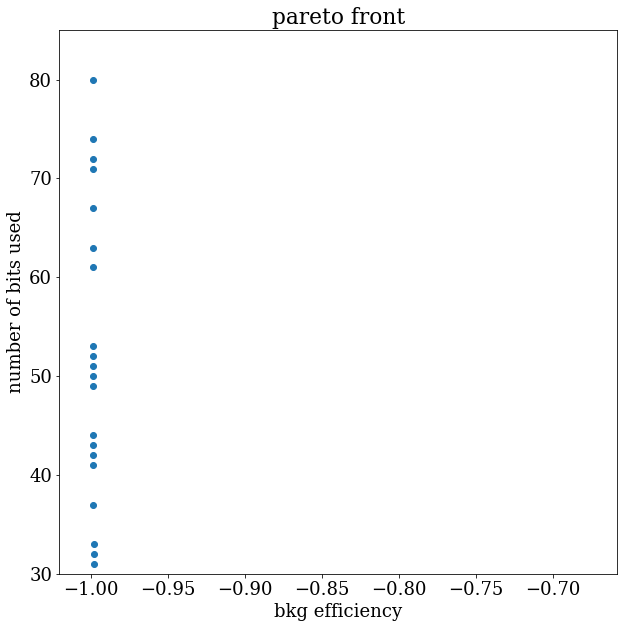

In [40]:
from pymoo.visualization.scatter import Scatter

Plot=Scatter(figsize=(10,10)).add(res.F).show()

#plt.vlines(x=f1, ymin=30, ymax= 85, label = "unquantized")
plt.ylim(30,85)
plt.xlabel('bkg efficiency')
plt.ylabel('number of bits used')
plt.title('pareto front')

In [58]:
res.history[0].pop.get("F")*(-1,1)

array([[  0.89926972,  16.        ],
       [  0.96297143,  32.        ],
       [  0.99651581,  48.        ],
       [  0.9977552 ,  64.        ],
       [  0.9981452 ,  80.        ],
       [  0.99846545,  96.        ],
       [  0.99861304, 112.        ],
       [  0.99865562, 128.        ],
       [  0.99872211, 160.        ],
       [  0.99864654, 144.        ],
       [  0.9987169 , 176.        ],
       [  0.99868939, 192.        ]])

In [74]:
import pickle as pkl
pkl.dump(res, open(savedir + '40gen_hyperdiag_auc.pkl', 'wb'))

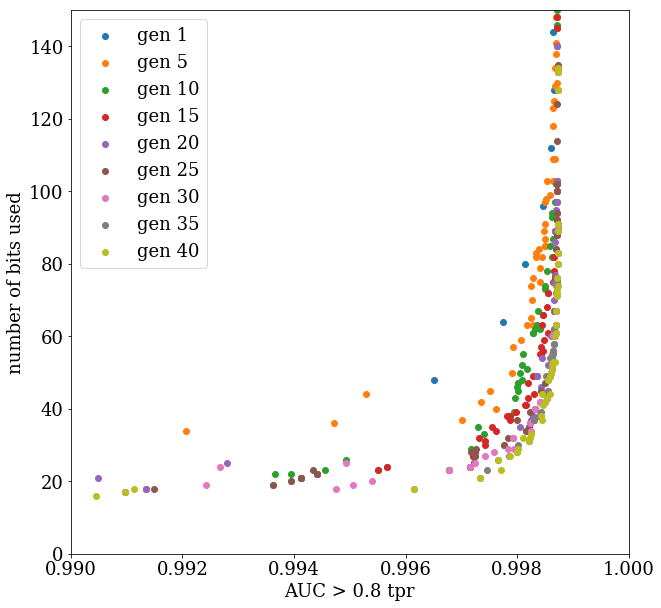

In [69]:
Plot=Scatter(figsize=(10,10))
Plot.add(res.history[0].pop.get("F")*(-1,1), label = 'gen {}'.format(1))
for i, hist in enumerate(res.history):
    if (i+1)%5==0:
        Plot.add(hist.pop.get("F")*(-1,1), label = 'gen {}'.format(i+1))
Plot.show()
#plt.vlines(x=f1, ymin=30, ymax= 170, label = "unquantized")
plt.ylim(0,150)
plt.xlim(0.99, 1)
plt.xlabel('AUC > 0.8 tpr')
plt.ylabel('number of bits used')
plt.legend()
plt.savefig(savedir + '40gen_hyperdiag_auc.png')

In [47]:
a=[100*a for (a,b) in res.F]
b=[int(b) for (a,b) in res.F]

In [63]:
features

['abseta',
 'cl3d_firstlayer',
 'varee',
 'varpp',
 'varzz',
 'varrr',
 'cl3d_meanz',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'EoT',
 'ebm1',
 'Emax_4R',
 'reverse_ebm1',
 'first_2',
 'Emax_2R',
 'Emax_5']

In [64]:
feats= ['abseta',
 '1stlay',
 'vee',
 'vpp',
 'vzz',
 'vrr',
 'meanz',
 'sho_lgth',
 'coreshlgth',
 'EoT',
 'ebm1',
 'Emax_4R',
 'rev_ebm1',
 'first_2',
 'Emax_2R',
 'Emax_5']

In [65]:
result= pd.DataFrame(res.X, columns=feats)
result['bkg_efficiency']=a
result['number of bits']=b

In [66]:
result.sort_values(["bkg_efficiency"])

,abseta,1stlay,vee,vpp,vzz,vrr,meanz,sho_lgth,coreshlgth,EoT,ebm1,Emax_4R,rev_ebm1,first_2,Emax_2R,Emax_5,bkg_efficiency,number of bits
5,10,6,4,10,10,10,9,6,6,10,10,5,10,7,10,10,-99.873225,133
14,5,6,2,10,2,11,1,2,2,0,11,5,11,6,1,5,-99.873175,80
33,5,2,2,9,2,11,1,1,2,0,11,6,10,6,1,5,-99.872862,74
31,5,1,2,12,1,11,0,2,2,0,11,6,8,6,0,5,-99.871794,72
29,5,6,2,10,2,10,1,1,0,1,11,5,9,2,1,5,-99.870753,71
36,5,1,2,10,1,10,1,1,3,1,11,5,9,2,0,5,-99.870450,67
2,4,1,1,10,2,10,0,1,3,1,11,5,8,1,0,5,-99.869946,63
13,4,1,1,9,2,10,0,1,0,1,11,5,9,1,1,5,-99.869178,61
25,4,0,1,9,2,10,0,1,0,1,10,0,8,1,1,5,-99.867623,53
9,5,0,0,9,1,9,0,1,0,1,11,0,8,1,1,5,-99.863076,52


In [ ]:
x=xu
qtrain=pd.DataFrame()
qtrain_uni=pd.DataFrame()
qtest=pd.DataFrame()
for i,feat in enumerate(X_train.columns):
    print("feature :", feat, "quantized on {} bits".format(x[i]))
    qtrain[feat]=quantize(X_train[feat], x[i], 'uniform', data[feat].min(), data[feat].max())
    #qtrain_uni[feat]=quantize(X_train[feat], x[i], 'uniform', data[feat].min(), data[feat].max())
    qtest[feat]=quantize(X_test[feat], x[i], 'uniform', data[feat].min(), data[feat].max())

train= xgb.DMatrix(data=X_train,label=y_train['signal'], feature_names=features)
test= xgb.DMatrix(data=X_test,label=y_test['signal'],feature_names=features)

#use gpu if available
gpu=tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
if gpu==True:
    param['tree_method']='gpu_hist'

num_boost_round=200
es_rounds=3

metrics={'logloss','auc'} #last one used for es
# set up cross validation:
#print('beginning cv')
cv_results = xgb.cv(
    param,
    train,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics=metrics,
    #feval=SoverB,
    early_stopping_rounds=es_rounds,
    shuffle=True,
    verbose_eval=None
)

## we define best score as the best test_auc penalized by the gap between train and test auc
alpha=1 #(penalization)

best_score=(cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).max()
boost_rounds = (cv_results['test-auc-mean']-alpha*abs(cv_results['test-auc-mean']-cv_results['train-auc-mean'])).argmax()
#Now train and fit best parameters BDT
eval_result = {}
BDT = xgb.train(
    param,
    train,
    num_boost_round=int(boost_rounds),
    #feval = SoverB,
    evals=[(train, 'Train'),(test, "Test")],
    evals_result = eval_result,
    verbose_eval=None,
)
pred= BDT.predict(test)
fpr, tpr, threshold = roc_curve(y_test['signal'],pred, pos_label=1)
fpr.sort()
tpr.sort()
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})

#return bkg eff at 0.99 signal efficiency
f1=np.interp(0.99,roc_test['tpr'],roc_test['fpr'])

#f2 = total numer of bits used
f2=int(sum(x))
print('done')

In [ ]:
f1

In [ ]:
perc = 7.6%
uni = 2.9%

In [ ]:
plt.figure(figsize=(10,10))
roc_auc_test = auc(fpr, tpr)
plt.plot(tpr,fpr, label =' AUC = {:2.2%}' .format(roc_auc_test))
plt.yscale('log')
plt.xlim(0.98,1.001)
plt.ylim(3e-2,5e-1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend(loc='upper left')
print(f1)

In [ ]:
Counter((qtrain['cl3d_firstlayer']))

In [ ]:
Counter(y_test['signal'])

In [ ]:
feat=X_train['cl3d_firstlayer']
nbits=4
method='percentile'
fmin=data['cl3d_firstlayer'].min()
fmax=data['cl3d_firstlayer'].max()
print(fmin, fmax)
 #feat is the feature to quantize, nbist the number of bits, method: 'uniform' or 'percentile'
nbins= 2**nbits
if method == 'uniform':
    bins=np.linspace(fmin, fmax, nbins+1)
elif method == 'percentile':
    bins=[np.percentile(feat, n) for n in np.linspace(0,100,nbins+1)]
else :
    print('Error: Invalid method')

print(bins)

np.digitize(feat, bins)

In [ ]:
np.linspace(0,100,16)

In [ ]:
X_train['cl3d_firstlayer']

In [ ]:
res

In [ ]:
sum(xu)

In [ ]:
6*16

In [ ]:
res.history

In [ ]:
for i,feat in enumerate(features):
    print(feat)
    plt.figure(figsize=(10,6))
    bins= xu[i]
    plt.hist(qtrain_uni[feat][y_train['signal']==0], bins = bins, label='uniform')
    plt.hist(qtrain[feat][y_train['signal']==0],bins = bins, histtype='step', label = 'percentile)')
    plt.title(feat)
    plt.legend()
    

In [ ]:
qtrain_uni

In [ ]:
for i,feat in enumerate(X_train.columns):
    print(feat,X_train[feat].dtype)